# Лабораторная работа: Анализ динамических систем
## Цель: 
Освоить численное решение систем ДУ, построение фазовых портретов в различных координатах, линеаризацию и анализ устойчивости.

---

## Часть 1: Линейные системы (2D)

Мы будем рассматривать систему:
$$\dot{x}=4x-t^2x,\quad x(0)=0$$

### Блок 1.1: Импорт библиотек

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

### Блок 1.2: Определение системы

In [46]:
def linear_system(t, state):
    x, y = np.asarray(state)
    dxdt = 4 * x - t**2 * x
    dydt = 0
    return np.array([dxdt, dydt])

### Блок 1.3: Фазовый портрет

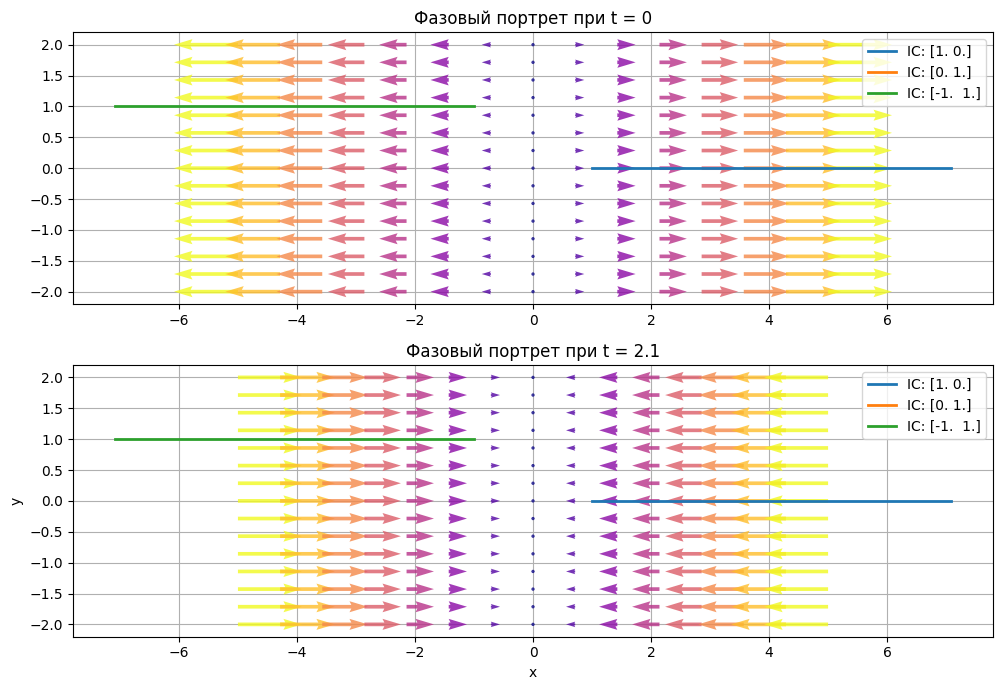

In [47]:
initial_conditions = [[1, 0], [0, 1], [-1, 1]]
solutions = []
time_interval = (0, 0.5)
for ic in initial_conditions:
    sol = solve_ivp(linear_system, time_interval, ic, t_eval=np.linspace(time_interval[0], time_interval[1], 1000))
    solutions.append(sol)
    
x = np.linspace(-5, 5, 15)
y = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x, y)

dX = np.zeros((2, X.shape[0], X.shape[1]))
dY = np.zeros_like(dX)

t = [0, 2.1]

for idx, t_i in enumerate(t):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            dx, dy = linear_system(t_i, [X[i, j], Y[i, j]])
            dX[idx, i, j] = dx
            dY[idx, i, j] = dy

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
for i, ax in enumerate(axes):
    ax.quiver(X, Y, dX[i], dY[i], np.hypot(dX[i], dY[i]), cmap='plasma', alpha=0.8)

    for sol in solutions:
        ax.plot(sol.y[0], sol.y[1], lw=2, label=f"IC: {sol.y[:,0]}")


    ax.grid(True)
    ax.legend()
    ax.set_axisbelow(True)
    ax.set_title(f"Фазовый портрет при t = {t[i]}")

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

#### Как собственные значения матрицы системы связаны с фазовыми портретом?
 
##### Устойчивоcть:
- Если оба $\text{Re}(\lambda)<0$: решения стремятся к началу координат — устойчивый узел или фокус
- Еcли оба $\text{Re}(\lambda)>0$: решения уходят от начала координат — неустойчивый узел или фокус
- Если $\text{Re}(\lambda)$ имеют разные знаки: есть направление притяжения и отталкивания — седло (всегда неустойчиво)

##### Тип траекторий
- Действительные и разные $\lambda$: фазовый портрет — узел (линии вдоль направлений собственных векторов)
- Действительные и противоположные $\lambda$: седло (траектории вдоль одного направления сходятся, вдоль другого — расходятся)

##### Комплексные $\lambda$:
- Если $\text{Re}(\lambda)\neq0$: фокус (спираль, закручивающаяся или раскручивающаяся)
- Если $\text{Re}(\lambda)=0$: центр (замкнутые орбиты, как окружности или эллипсы)

**В нашем случае, поскольку $y$ не дан, по данному направлению будем считать, что $\dot{y}=0$, и при $t\in[0,2)$ траектории убегают от центра, а при $t\in[2,+\infty)$ сходятся к центру обратно.** 

## Часть 2: Нелинейные системы (2D)

Система: 
$$
\begin{cases}
\dot{x} = y + x(1 - x^2 - y^2) \\
\dot{y} = -x + y(1 - x^2 - y^2)
\end{cases}
$$

### Блок 2.1: Точки покоя 

Найдём аналитически:
$$\begin{cases}
y + x(1 - x^2 - y^2)=0 \\
-x + y(1 - x^2 - y^2)=0
\end{cases}\Rightarrow
y(1+(1 - x^2 - y^2)^2)=0\Rightarrow \text{Единственная точка покоя (0, 0)}
$$

In [48]:
#Реализуем поиск точек покоя
x, y = sp.symbols('x y')
dxdt = y + x * (1 - x**2 - y**2)
dydt = y * (1 - x**2 - y**2) - x

equilibrium_points = sp.solve([dxdt, dydt], (x, y), dict=True)

for sol in equilibrium_points:
    print({k: sp.simplify(v) for k, v in sol.items()})

{x: 0, y: 0}


In [49]:
def nonlinear_system(t, state):
    x, y = np.asarray(state)
    dxdt = y + x * (1 - x**2 - y**2)
    dydt = y * (1 - x**2 - y**2) - x 
    return np.array([dxdt, dydt])

### Блок 2.2: Линеаризация

Якобиан:
$$
J(x, y) =
\begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{bmatrix}
$$
В нашем случае:
$$
J(x, y) = 
\begin{bmatrix}
1 - y^2 - 3x^2 & 1 - 2xy \\
-1 - 2xy & 1 - x^2 - 3y^2
\end{bmatrix}
$$

In [50]:
def jacobian(state):
    x, y = np.asarray(state)
    dfdx = 1 - y**2 - 3 * x**2
    dfdy = 1 - x * 2 * y
    dgdx = -1 - y * 2 * x
    dgdy = 1 - x**2 - 3 * y**2
    return np.array([[dfdx, dfdy], 
                     [dgdx, dgdy]])

non_linear_Jac = jacobian((0, 0))
print(f"Якобиан в точке покоя:\n{non_linear_Jac}")

Якобиан в точке покоя:
[[ 1  1]
 [-1  1]]


Определим тип точки покоя:
$(1-\lambda)^2=-1\Rightarrow \lambda=1\pm i\Rightarrow$ неустойчивый фокус

Найдём предельные циклы, перейдя в полярные координаты:

In [51]:
r, theta = sp.symbols('r theta', real=True, positive=True)
x_cycle = r * sp.cos(theta)
y_cycle = r * sp.sin(theta)
dxdt = y_cycle + x_cycle  * (1 - x_cycle**2 - y_cycle**2)
dydt = -x_cycle + y_cycle  * (1 - x_cycle**2 - y_cycle**2)

drdt = (x_cycle * dxdt + y_cycle * dydt) / r
drdt_simplified = sp.simplify(drdt)
roots = sp.solve(drdt_simplified, r)

print(f"dr/dt ={drdt_simplified}")
print("\nПредельные циклы:")
for root in roots:
    print(f"r = {root.evalf()}")

dr/dt =-r**3 + r

Предельные циклы:
r = 1.00000000000000


### Блок 2.3: Фазовый портрет 

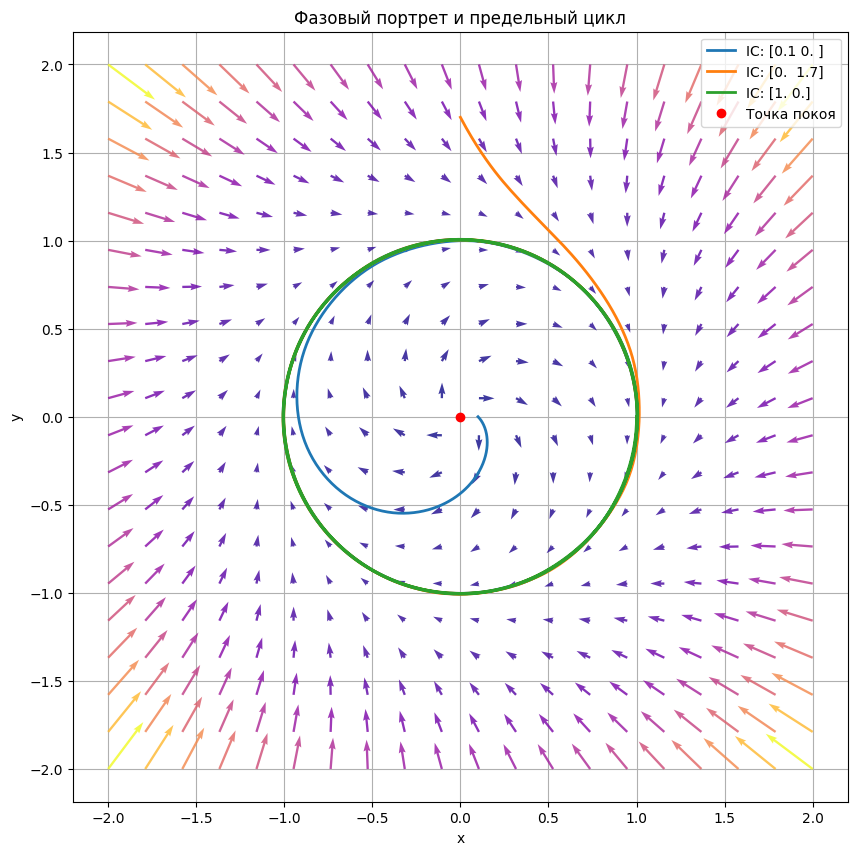

In [52]:
x_vals = np.linspace(-2, 2, 20)
y_vals = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x_vals, y_vals)
U = np.zeros_like(X)
V = np.zeros_like(Y)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dx, dy = nonlinear_system(0, [X[i, j], Y[i, j]])
        U[i, j] = dx
        V[i, j] = dy

R = np.sqrt(X**2 + Y**2)
scale = 1 / R**1.1
U_scaled = U * scale
V_scaled = V * scale

plt.figure(figsize=(10, 10))
plt.quiver(X, Y, U_scaled, V_scaled, np.hypot(U, V), cmap="plasma", alpha=0.8)

initial_conditions = [[0.1, 0], [0, 1.7], [1, 0]]

for ic in initial_conditions:
    sol = solve_ivp(nonlinear_system, [0, 20], ic, t_eval=np.linspace(0, 20, 1000))
    plt.plot(sol.y[0], sol.y[1], lw=2, label=f"IC: {sol.y[:,0]}")

for pt in equilibrium_points:
    x0 = float(pt[x])
    y0 = float(pt[y])
    plt.plot(x0, y0, 'ro', label="Точка покоя")

plt.title("Фазовый портрет и предельный цикл")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.legend()
plt.gca().set_axisbelow(True) 
plt.grid(True)
plt.show()

Имеем единственный предельный цикл $x^2+y^2=1$ (притягивающий)
## Часть 3: Системы в полярных координатах 

Система с контеста

### Блок 3.1: Преобразование

In [53]:
def polar_system(t, state):
    r, theta = state
    # TODO: Реализуйте уравнения (используйте np.array)
    drdt = ...
    dthetadt = ...
    return np.array([drdt, dthetadt])

### Блок 3.2: Визуализация 

In [54]:
# TODO: Постройте фазовый портрет в декартовых координатах

## Часть 4: Рефлексия 

Передохните немного :)

## Часть 5: Системы в цилиндрических координатах (1 вариант)

Система: 
$$
\begin{cases}
\dot{r} = r(1 - z) \\
\dot{\theta} = 2 \\
\dot{z} = z(3 - r^2)
\end{cases}
$$

### Блок 5.1: Преобразование и визуализация 

In [55]:
def cylindrical_system(t, state):
    r, theta, z = state
    # TODO: Реализуйте уравнения (используйте np.array)
    drdt = ...
    dthetadt = ...
    dzdt = ...
    return np.array([drdt, dthetadt, dzdt])

# TODO: Постройте 3D-фазовый портрет и проекции на (r,z) и (x,y)

## Часть 6: Системы в сферических координатах (2 вариант)

Система: 
$$
\begin{cases}
\dot{r} = r(1 - r) \\
\dot{\theta} = \sin\theta \\
\dot{\phi} = 1
\end{cases}
$$

### Блок 6.1: Преобразование и визуализация

In [56]:
def spherical_system(t, state):
    r, theta, phi = state
    # TODO: Реализуйте уравнения (используйте np.array)
    drdt = ...
    dthetadt = ...
    dphidt = ...
    return np.array([drdt, dthetadt, dphidt])

# TODO: Постройте 3D-фазовый портрет

## Часть 7: Автоматизация анализа 

Задача:  Функция для анализа устойчивости. Для программистов :)

In [57]:
def analyze_stability(jacobian_matrix, equilibrium_point):
    # TODO:
    # 1. Вычислите собственные значения
    # 2. Определите тип точки покоя
    # 3. Верните результат в виде строки
    return "Тип устойчивости"

## Часть 8: Физическая задача - Планер
Исследовать динамику безмоторного летательного аппарата в координатах $ xz $, анализировать точки покоя, строить фазовые портреты и сравнивать с физическим экспериментом.

---

### Часть 8.1: Идеальный планёр ($ D = 0 $)  
**Система уравнений:**  
$$
\begin{cases}
\dot{\theta} = \frac{v^2 - \cos\theta}{v}, \\\\
\dot{v} = -\sin\theta - Dv^2,
\end{cases}
$$
где $D$ – аэродинамическая характеристика, которая показывает отношение лобового сопротивления воздуха к подъёмной силе. Конструкторы обычно стараются сделать её как можно меньше.

**Теория:**  
Точки покоя определяются из условий $ \dot{\theta} = 0 $ и $ \dot{v} = 0$.  
**Физический смысл:**  
TODO

Линеаризуйте систему около точек покоя, пользуясь той же идеей, что и в первой части. Определите тип точек покоя, постройте фазовый портрет в окрестностях этих точек. Какое поведение можно ожидать около этих точек?

### Блок 8.1: Реализация системы 

In [58]:
# TODO:
# 1. Решите системы
# 2. Постройте фазовые траектории на одном графике
# 3. Добавьте векторное поле (используйте plt.quiver)

### Блок 8.2: Реально моделирование

**Определение.**  
Функция $ u \in C^1 $ называется **первым интегралом системы** $\dot{y} = f(y)$, если для любого решения $ y(t) $ этой системы выполнено:
$$
u(y(t)) = \text{const}.
$$

**Объяснение:**  
Первые интегралы являются важным инструментом для анализа динамических систем, так как они сохраняются вдоль траекторий системы. Это свойство позволяет:  
- Упростить анализ поведения системы.  
- Проверить корректность численных решений.  
- Найти дополнительные связи между переменными системы.

**Пример нахождения первого интеграла:**  
Один из способов (который не всегда может сработать) — исключить производные по времени путем деления одного уравнения системы на другое. Тогда решение полученного уравнения, записанное в виде:
$$
F(\theta, v) = \text{const},
$$
является первым интегралом.

1. **Фазовый портрет и симуляция движения**  
   Постройте общий фазовый портрет системы. Просимулируйте движение планёра в координатах $ xz $ при различных начальных условиях.  
   - Выделите траектории, соответствующие движению планёра, на фазовом портрете.  
   - Учтите, что самолёт не может летать ниже уровня \( z = 0 \) метров (высота не может быть отрицательной).  

2. **Исследование систем с различными значениями $ D $**  
   Исследуйте системы для $ D \in (0, 1) $ и $ D \in (1, 2) $:  
   - Постройте фазовые портреты.  
   - Просимулируйте движение планёра при различных начальных условиях, демонстрирующих кардинально разное поведение самолёта.  
   - Поясните, почему возникают такие отличия.  

3. **Эксперимент с бумажным самолётиком**  
   - Сложите самолётик из бумаги формата А5 (половина обычного листа).  
   - Примите за $ D $ отношение расстояния, которое пролетел самолётик по оси $ x $, к высоте, с которой он был запущен (при нулевой начальной скорости и нулевом угле наклона).  
   - Запустите самолётик несколько раз, измерьте расстояние полёта и высоту запуска, чтобы вычислить $ D $.  
   - Сравните результаты эксперимента с графиками, полученными в симуляции.  
   - Научитесь находить по полёту самолётика и примерным начальным условиям (которые вы задаёте рукой) соответствующее место на фазовом портрете.  
   - Снимите результат на видео и сравните с моделированием.
